In [ ]:

! pip install datasets==3.3.2
! pip install loguru==0.7.3
! pip install numpy==2.2.3
! pip install torch==2.6.0
! pip install tqdm==4.67.1
! pip install transformers==4.49.0

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [ ]:
    pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.3 MB/s eta 0:00:00


### Muon sudo code

Input: γ (learning rate), θ₀ (parameters), f(θ) (objective), λ (weight decay),
       μ (momentum), τ (dampening), nesterov, maximize, NS_steps. <br>


for t = 1 to ... do

    if maximize:
        g_t ← -∇_θ f_t(θ_{t-1})
    else:
        g_t ← ∇_θ f_t(θ_{t-1})
    
    if λ ≠ 0:
        θ_t ← θ_{t-1}·(1 - γ·λ)  # Apply weight decay directly to parameters
    
    b_t ← g_t  # Initialize buffer with current gradient
    
    if μ ≠ 0:
        if t > 1:
            b_t ← μ·b_{t-1} + (1-τ)·g_t  # Apply momentum
        
        if nesterov:
            b_t ← g_t + μ·b_t  # or b_t ← (1-μ)·g_t + μ·b_t
    
    # Muon: Apply Newton-Schulz orthogonalization for matrix parameters
    if dim(b_t) ≥ 2:
        # Save original shape
        original_shape ← shape(b_t)
        
        # Reshape to 2D if needed
        if dim(b_t) > 2:
            b_t ← reshape(b_t, [size(b_t, 0), -1])
        
        # Apply Newton-Schulz orthogonalization
        b_t ← NewtonSchulz5(b_t, NS_steps)
        
        # Apply scaling factor for consistent update magnitude
        b_t ← b_t · √max(1, size(b_t, -2)/size(b_t, -1))
        
        # Restore original shape if needed
        if dim(original_shape) > 2:
            b_t ← reshape(b_t, original_shape)
    
    θ_t ← θ_{t-1} - γ·b_t  # Update parameters

return θ_t

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim


def zeropower_via_newtonschulz5(G, steps: int):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(-2) > G.size(-1):
        X = X.mT
    return X


def muon_update(grad, momentum, beta=0.95, ns_steps=5, nesterov=True):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum*beta + grad*(1-beta) if nesterov else momentum

    if update.ndim == 4:  # for the case of conv filters
        update = update.view(update.shape[0], -1)  # keep first dim, flatten the rest

    update = zeropower_via_newtonschulz5(update, steps=ns_steps)
    update *= max(1, grad.size(-2) / grad.size(-1))**0.5
    return update


class Muon(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.95, steps=5,
                 weight_decay=0, nesterov=True, maximize=False):

        defaults = dict(lr=lr, momentum=momentum, steps=steps,
                        weight_decay=weight_decay, nesterov=nesterov)
        self.maximize = maximize
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            steps = group['steps']
            weight_decay = group['weight_decay']
            nesterov = group['nesterov']


            for p in group['params']:
                if p.grad is None:
                    continue

                if self.maximize:
                    grad = -p.grad
                else:
                    grad = p.grad

                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply zeropower_via_newtonschulz5 if parameter is a matrix
                if p.ndim >= 2:
                    org_shape = p.shape
                    orthogonal_buff = muon_update(grad, state["momentum_buffer"],
                                                beta=momentum, ns_steps=steps, nesterov=nesterov)
                    if p.ndim == 4:
                        orthogonal_buff = orthogonal_buff.view(org_shape)

                    # Apply update to parameters
                    p.add_(orthogonal_buff, alpha=-lr)
                else:
                    # For non-matrix parameters, use standard momentum update
                    buf = state['momentum_buffer']
                    buf.mul_(momentum).add_(grad)

                    # furhter modify buf if nesterov
                    if nesterov:
                        buf = grad + momentum * buf

                    # Apply update to parameters
                    p.add_(buf, alpha=-lr)

        return loss

In [2]:
import torch.nn as nn
import torch
import torch.optim as optim

def optimized_zeropower_via_newtonschulz5(G, steps=5, eps=1e-7):

    # Instead of Python loop, use JIT compilation
    @torch.jit.script
    def newton_schulz_iteration(X, a: float, b: float, c: float):
        A = torch.matmul(X, X.transpose(-2, -1))
        B = b * A + c * torch.matmul(A, A)
        return a * X + torch.matmul(B, X)


    # Move to GPU early and stay there
    device = G.device
    dtype = G.dtype

    # Convert to contiguous tensors for faster GPU operations
    G = G.contiguous()

    # Use bfloat16 for faster computation
    X = G.to(torch.bfloat16)

    # Handle tall matrices
    is_tall = X.size(-2) > X.size(-1)
    if is_tall:
        X = X.transpose(-2, -1)

    # Normalize
    #X.div_(X.norm(dim=(-2, -1), keepdim=True) + eps)
    # Ensure spectral norm is at most 1 - use fused operations when possible
    norm = torch.linalg.norm(X, dim=(-2, -1), keepdim=True)
    X = torch.div(X, norm + eps)  # Using torch.div is sometimes faster than / operator

    # Newton-Schulz iterations
    a, b, c = (3.4445, -4.7750, 2.0315)
    """
    for _ in range(steps):
        A = X @ X.transpose(-2, -1)
        B = b * A + c * (A @ A)
        X = a * X + B @ X
    """
      # Apply iterations
    for _ in range(steps):
        X = newton_schulz_iteration(X, a, b, c)


    if is_tall:
        X = X.transpose(-2, -1)

    # Convert back to original precision
    return X.to(G.dtype)



def optimized_muon_update(grad, momentum, beta=0.95, steps=5, nesterov=True):
    # Update momentum in-place
    momentum.mul_(beta).add_(grad, alpha=1-beta)

    # Compute update
    if nesterov:
        # Create update without modifying grad
        update = grad * (1-beta) + momentum * beta
    else:
        update = momentum.clone()

    # Handle reshaping
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Apply orthogonalization
    update = optimized_zeropower_via_newtonschulz5(update, steps=steps)

    # Apply scaling
    scale_factor = max(1, update.size(-2) / update.size(-1))**0.5
    update.mul_(scale_factor)

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update

class OptimizedMuon(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.95, steps=5,
                 weight_decay=0, nesterov=True):
        defaults = dict(lr=lr, momentum=momentum, steps=steps,
                       weight_decay=weight_decay, nesterov=nesterov)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            steps = group['steps']
            weight_decay = group['weight_decay']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad

                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(grad)

                # Apply weight decay
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply Muon update for matrix parameters
                if p.ndim >= 2:
                    update = optimized_muon_update(grad, state['momentum_buffer'],
                                                beta=momentum, steps=steps,
                                                nesterov=nesterov)
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, use standard momentum update
                    buf = state['momentum_buffer']
                    buf.mul_(momentum).add_(grad)

                    if nesterov:
                        update = grad + momentum * buf
                    else:
                        update = buf

                    p.add_(update, alpha=-lr)

        return loss


--- Training with Muon ---
Muon | Epoch 1, avg loss: 0.2778, time: 9.70 seconds
Muon | Epoch 2, avg loss: 0.0680, time: 9.65 seconds
Muon | Epoch 3, avg loss: 0.0475, time: 9.51 seconds
Muon | Total training time: 28.86 seconds

--- Training with SGD ---
SGD | Epoch 1, avg loss: 1.7083, time: 7.29 seconds
SGD | Epoch 2, avg loss: 0.5566, time: 7.24 seconds
SGD | Epoch 3, avg loss: 0.3931, time: 7.30 seconds
SGD | Total training time: 21.84 seconds

--- Training with AdamW ---
AdamW | Epoch 1, avg loss: 0.2847, time: 7.63 seconds
AdamW | Epoch 2, avg loss: 0.1075, time: 7.50 seconds
AdamW | Epoch 3, avg loss: 0.0717, time: 7.58 seconds
AdamW | Total training time: 22.71 seconds


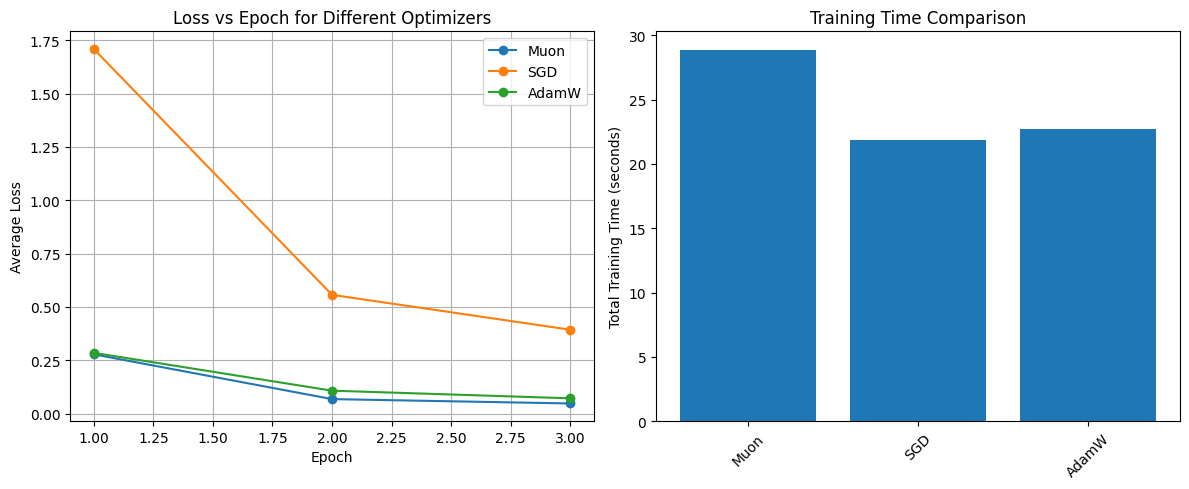


--- Performance Summary ---
Optimizer | Final Loss | Total Time (s) | Relative Speed
Muon         | 0.0475     | 28.86          | 1.32x
SGD          | 0.3931     | 21.84          | 1.00x
AdamW        | 0.0717     | 22.71          | 1.04x


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time  # Import time module for timing

# --- your optimizer import here ---
# from muon import Muon

# Simple MLP for MNIST
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Dataset & loader
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2),
    #"OptimizedMuon": lambda params: OptimizedMuon(params, lr=1e-2),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=0.001, weight_decay=0.01),
}

results = {}  # store loss curves
time_results = {}  # store timing information

for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = MLP().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    losses = []
    epoch_times = []

    for epoch in range(1, 4):  # just 3 epochs to test
        epoch_start_time = time.time()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, time: {epoch_duration:.2f} seconds")

    results[opt_name] = losses
    time_results[opt_name] = epoch_times

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Time vs Optimizer
plt.subplot(1, 2, 2)
opt_names = list(time_results.keys())
total_times = [sum(times) for times in time_results.values()]
plt.bar(opt_names, total_times)
plt.ylabel("Total Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also print a summary table
print("\n--- Performance Summary ---")
print("Optimizer | Final Loss | Total Time (s) | Relative Speed")
fastest_time = min(total_times)
for i, opt_name in enumerate(opt_names):
    final_loss = results[opt_name][-1]
    total_time = total_times[i]
    relative_speed = total_time / fastest_time
    print(f"{opt_name:12} | {final_loss:.4f}     | {total_time:.2f}          | {relative_speed:.2f}x")


--- Training with Muon ---
Epoch [1/5], Step [100/391], Loss: 1.5581
Epoch [1/5], Step [200/391], Loss: 1.3923
Epoch [1/5], Step [300/391], Loss: 1.0872
Muon | Epoch 1, avg loss: 1.4218, test acc: 68.08%, time: 10.11 seconds
Epoch [2/5], Step [100/391], Loss: 0.9976
Epoch [2/5], Step [200/391], Loss: 0.8543
Epoch [2/5], Step [300/391], Loss: 0.8937
Muon | Epoch 2, avg loss: 0.9570, test acc: 74.27%, time: 9.95 seconds
Epoch [3/5], Step [100/391], Loss: 0.8981
Epoch [3/5], Step [200/391], Loss: 0.8618
Epoch [3/5], Step [300/391], Loss: 0.7957
Muon | Epoch 3, avg loss: 0.8087, test acc: 76.90%, time: 9.87 seconds
Epoch [4/5], Step [100/391], Loss: 0.6446
Epoch [4/5], Step [200/391], Loss: 0.6023
Epoch [4/5], Step [300/391], Loss: 0.7697
Muon | Epoch 4, avg loss: 0.6992, test acc: 79.84%, time: 9.80 seconds
Epoch [5/5], Step [100/391], Loss: 0.6941
Epoch [5/5], Step [200/391], Loss: 0.7476
Epoch [5/5], Step [300/391], Loss: 0.6611
Muon | Epoch 5, avg loss: 0.6279, test acc: 80.79%, time:

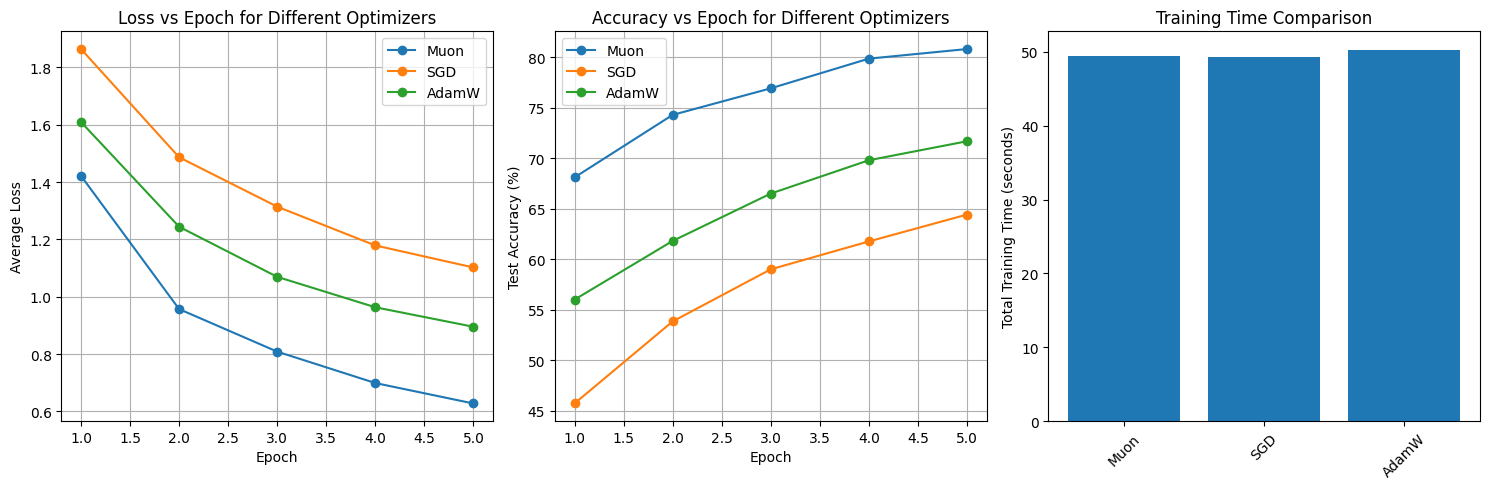


--- Performance Summary ---
Optimizer | Final Loss | Final Acc (%) | Total Time (s) | Relative Speed
Muon         | 0.6279     | 80.79        | 49.47          | 1.00x
SGD          | 1.1023     | 64.40        | 49.30          | 1.00x
AdamW        | 0.8955     | 71.66        | 50.25          | 1.02x


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Import your optimizers
# from muon import Muon, OptimizedMuon

# Define a more substantial CNN for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Dataset & loader with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Increase batch size for more realistic training
batch_size = 128

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2),
    # "OptimizedMuon": lambda params: OptimizedMuon(params, lr=1e-3),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=5e-4),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4),
}

results = {}  # store loss curves
accuracy_results = {}  # store accuracy curves
time_results = {}  # store timing information

# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies
    time_results[opt_name] = epoch_times

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 3, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 3. Time vs Optimizer
plt.subplot(1, 3, 3)
opt_names = list(time_results.keys())
total_times = [sum(times) for times in time_results.values()]
plt.bar(opt_names, total_times)
plt.ylabel("Total Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also print a summary table
print("\n--- Performance Summary ---")
print("Optimizer | Final Loss | Final Acc (%) | Total Time (s) | Relative Speed")
fastest_time = min(total_times)
for i, opt_name in enumerate(opt_names):
    final_loss = results[opt_name][-1]
    final_acc = accuracy_results[opt_name][-1]
    total_time = total_times[i]
    relative_speed = total_time / fastest_time
    print(f"{opt_name:12} | {final_loss:.4f}     | {final_acc:.2f}        | {total_time:.2f}          | {relative_speed:.2f}x")